# Segmenting and Clustering Neighborhoods

+ beautifulsoup get web table
+ postal data process
+ geo location data merge
+ map with folium
+ cluster and visualization

## import package

In [ ]:
import pandas as pd
from urllib.request import urlopen
from bs4 import BeautifulSoup
import ssl
ssl._create_default_https_context = ssl._create_unverified_context

## get postal data

In [39]:
# get postal code data with beautifulsoup
url = "https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M"
html = urlopen(url)
soup = BeautifulSoup(html, "html.parser")

with open("data/postal_codes_sp.csv","w") as fp:
    title = "Postcode,Borough,Neighbourhood"
    tables = soup.findAll('table')
    tab = tables[0]
    
    fp.write(title)
    for tr in tab.tbody.findAll('tr'):
        row = []
        for td in tr.findAll('td'):
            row.append(td.get_text().replace("\n", ""))
        fp.write(",".join(row))
        fp.write('\n')

## postal data process by pandas

In [40]:
df = pd.read_csv("data/postal_codes_sp.csv")
df.head(10)

Postcode           Borough     Neighbourhood
0      M1A      Not assigned      Not assigned
1      M2A      Not assigned      Not assigned
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront
5      M6A        North York  Lawrence Heights
6      M6A        North York    Lawrence Manor
7      M7A  Downtown Toronto      Queen's Park
8      M8A      Not assigned      Not assigned
9      M9A         Etobicoke  Islington Avenue

In [41]:
# drop "Not assigned" Borough and set "Not assigned" Neighbourhood
df = df[~df['Borough'].isin(["Not assigned"])]
df["Neighbourhood"][df['Neighbourhood']=="Not assigned"] = df["Borough"][df['Neighbourhood']=="Not assigned"]
df.head(5)

Postcode           Borough     Neighbourhood
2      M3A        North York         Parkwoods
3      M4A        North York  Victoria Village
4      M5A  Downtown Toronto      Harbourfront
5      M6A        North York  Lawrence Heights
6      M6A        North York    Lawrence Manor

In [44]:
# join Neighbourhood for same Postcode and Borough
df_post = df.groupby(["Postcode", "Borough"])["Neighbourhood"].apply(lambda x: ','.join(x))
df_post = df_post.reset_index()
df_post.head(10)

Postcode      Borough                                  Neighbourhood
0      M1B  Scarborough                                  Rouge,Malvern
1      M1C  Scarborough           Highland Creek,Rouge Hill,Port Union
2      M1E  Scarborough                Guildwood,Morningside,West Hill
3      M1G  Scarborough                                         Woburn
4      M1H  Scarborough                                      Cedarbrae
5      M1J  Scarborough                            Scarborough Village
6      M1K  Scarborough      East Birchmount Park,Ionview,Kennedy Park
7      M1L  Scarborough                  Clairlea,Golden Mile,Oakridge
8      M1M  Scarborough  Cliffcrest,Cliffside,Scarborough Village West
9      M1N  Scarborough                     Birch Cliff,Cliffside West

In [45]:
df_post.shape

(103, 3)

## geo data join with postal

In [57]:
df_geo = pd.read_csv("data/Geospatial_Coordinates.csv")
df_geo.rename(columns={"Postal Code":"Postcode"}, inplace=True)
df_geo.head(3)

Postcode   Latitude  Longitude
0      M1B  43.806686 -79.194353
1      M1C  43.784535 -79.160497
2      M1E  43.763573 -79.188711

In [58]:
df = pd.merge(df_post, df_geo, how="inner", on="Postcode")
df.head()

Postcode      Borough                         Neighbourhood   Latitude  \
0      M1B  Scarborough                         Rouge,Malvern  43.806686   
1      M1C  Scarborough  Highland Creek,Rouge Hill,Port Union  43.784535   
2      M1E  Scarborough       Guildwood,Morningside,West Hill  43.763573   
3      M1G  Scarborough                                Woburn  43.770992   
4      M1H  Scarborough                             Cedarbrae  43.773136   

   Longitude  
0 -79.194353  
1 -79.160497  
2 -79.188711  
3 -79.216917  
4 -79.239476

## map with folium

In [75]:
# center toronto location
center_toronto = df[df["Borough"]=="Central Toronto"]

toronto_latitude = center_toronto.iloc[0].Latitude
toronto_longitude = center_toroton.iloc[0].Longitude

In [84]:
# all postal location
latitude = df.Latitude.values
longitude = df.Longitude.values
location = df.Borough.values

In [85]:
import folium
venues_map = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=13) # generate map centred around the Conrad Hotel

# add a red circle marker
folium.CircleMarker(
    [toronto_latitude, toronto_longitude],
    radius=10,
    color='red',
    popup='Conrad Hotel',
    fill = True,
    fill_color = 'red',
    fill_opacity = 0.6
).add_to(venues_map)

# add to blue circle markers
for lat, lng, label in zip(latitude, longitude, location):
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        color='blue',
        popup=label,
        fill = True,
        fill_color='blue',
        fill_opacity=0.6
    ).add_to(venues_map)

# display map
venues_map

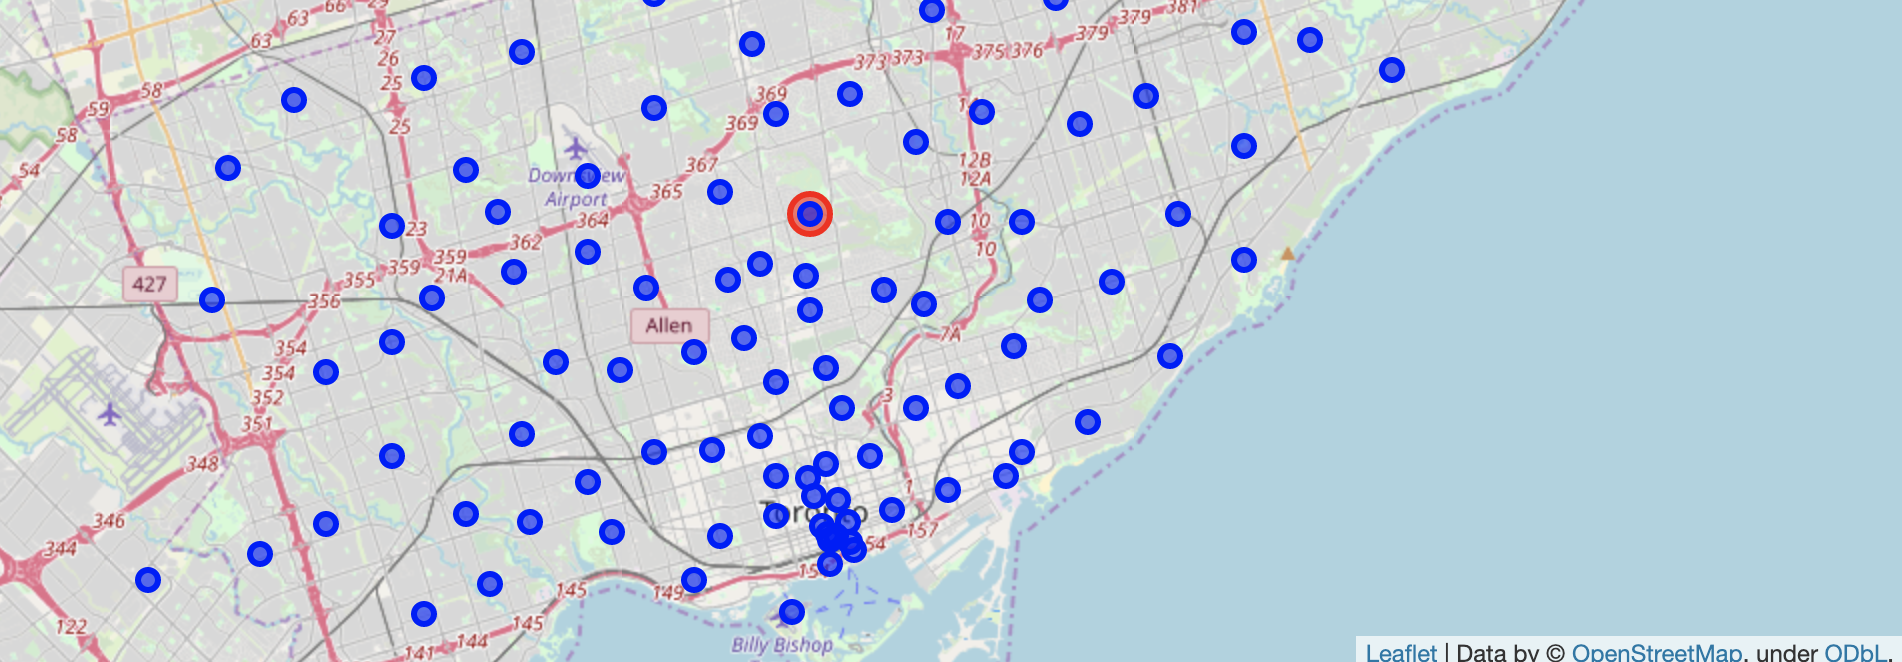

## cluster and visualization

In [80]:
from sklearn.cluster import KMeans

# set number of clusters
kclusters = 5

data = df[["Latitude", "Longitude"]]

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(data)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 0, 0, 0, 0, 0, 2, 0, 2], dtype=int32)

In [82]:
import folium
venues_map = folium.Map(location=[toronto_latitude, toronto_longitude], zoom_start=13) # generate map centred around the Conrad Hotel

colors = ["red", "blue", "yellow", "orange", "gray"]

# add to every clusters
for i in range(5):
    latitude = df[kmeans.labels_==i].Latitude.values
    longitude = df[kmeans.labels_==i].Longitude.values
    location = df[kmeans.labels_==i].Borough.values
    for lat, lng, label in zip(latitude, longitude, location):
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            color=colors[i],
            popup=label,
            fill = True,
            fill_color='blue',
            fill_opacity=0.6
        ).add_to(venues_map)

# display map
venues_map

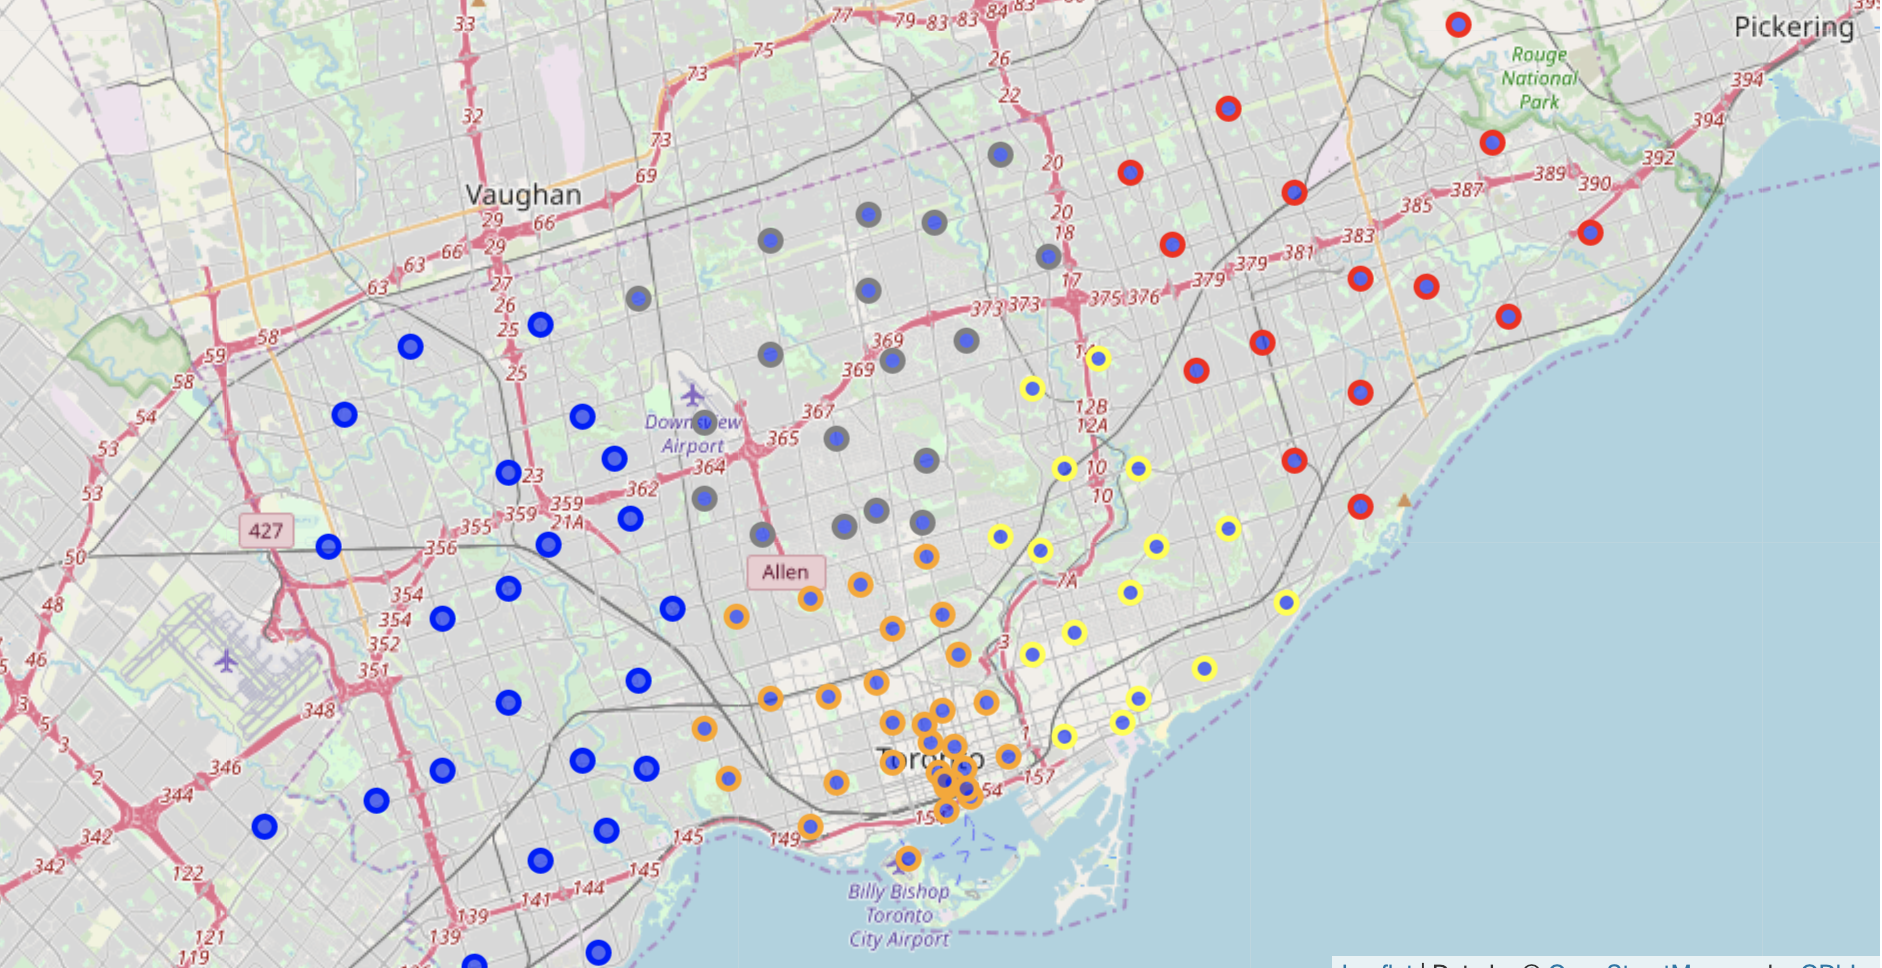